# Notebook to Preprocess MIMIC-III v1.4 Data Files

In this notebook we will preprocess the [MIMIC-III](https://physionet.org/content/mimiciii/1.4/) v1.4 data files as extracted by [MIMIC-Code](https://github.com/MIT-LCP/mimic-code).

The output of this notebook will be a pandas `DataFrame` (stored as a CSV file) with six columns:
- `episode`: An identifier for each ICU admission
- `timestep`: A `DateTime` object specifying the exact time a point measurement was made (e.g. `heart_rate`) or an interval was sampled (e.g. `max_vaso`)
- `x0`\*: An integer identifier specifying the type of measurement recorded at this timestep, e.g., a `heart_rate` measurement (`5`) or a lab result, such as `trombo` levels (`32`).
- `x1`\*: The value of the actual measurement in the appropriate unit (e.g. ml, bmp, mmHg)
- `x2`\*: `timestep` converted to hours relative to the start of treatment phase (set to 24h prior to sepsis onset)
- `reward`: Reward accrued at each decision point (`NaN` for non-decision points)
- `action`: Action taken at each decision point (`NaN` for non-decision points)

\* we use the `x*` notation for this state space to allow us to use the exact same training scripts for Q-learning also for the transformer encoder.

Measurements in the dataset are primarily timestamped point measurements (see EDA), that is *values recorded at specific times*; however, **vasopressor** and **IV fluid intake** are recorded in terms of `(starttime, endtime)` intervals. As these treatments are actions in our **action space**, we sample them every 4 hours much like Roggeveen et al., allowing direct comparison of actions taken at the same points in time.

**Important**: Make sure to run the `MIMIC-III_preprocessing_roggeveen.ipynb` notebook first, as the trainval/test split is made there and reused to create an identical dataset split here.

In [1]:
# Dependencies
import os
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Settings
INTERVAL_TIME = '1h'     # How often do we make a decision

USE_CAREVUE = False
DATA_DIR = '../data/mimic-iii/final/'                      # Where dataset is stored
OUTPUT_DIR_ROGGEVEEN = 'datasets/mimic-iii/aggregated_4h'  # We will be reusing the train/valid/test split and action space made previously
OUTPUT_DIR = 'datasets/mimic-iii/non_aggregated'           # Where preprocessed data will be stored

In [2]:
# Check whether previous notbooks have been executed and data is in the right location
if not os.path.exists(OUTPUT_DIR_ROGGEVEEN):
    raise Exception('Cannot find %s. Please run `MIMIC-III_preprocessing_aggregated.ipynb`.' % OUTPUT_DIR_ROGGEVEEN)

if not os.path.exists(DATA_DIR):
    raise Exception('Dataset directory %s does not exist!' % DATA_DIR)

# Create output_dir if not yet created
OUTPUT_DIR = OUTPUT_DIR + '_%s%s/' % (INTERVAL_TIME, '_with_cv' if USE_CAREVUE else '')
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
print('Good to go!')

Good to go!


### Convenience functions

We define some convenience funxtions which we can reuse throughout the notebook (e.g. for data loading, plotting, unit conversions, etc.)

In [3]:
def read_csv(fname):
    """ Read CSV from file 
    """
    df = pd.read_csv(fname)
    
    # Mad explicit as parse_dates of pd.read_csv fails to identify starttime and endtime
    parse_dates = ['intime', 'outtime', 'starttime', 'endtime', 'window_start', 
                   'window_end', 'charttime', 'suspected_infection_time_poe']
    
    for col in parse_dates:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    return df

def plot_single(df, item_id, title='', xlabel='Timestep', ylabel='Value', style='.-'):
    """ Plots values of certain item_id (e.g. heart_rate) for a random patient 
    """
    # Randomly choose icustay_id with data for item_id
    icustay_id = None
    while icustay_id is None:
        icustay_id = random.choice(list(set(df['episode'])))
        num_values = (df[(df['type'] == item_id) & (df['episode'] == icustay_id)]['value'] != 0).sum()
        icustay_id = None if num_values == 0 else icustay_id
        
    # Limit to item_id and chosen icustay_id
    df = df[(df['type'] == item_id) & (df['episode'] == icustay_id)]
        
    plt.figure(figsize=(8, 3))
    plt.plot(df['timestep'], df['value'], style)
    plt.title('%s (icustay_id=%d)' % (title, icustay_id))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def to_hours(x):
    """ Converts TimeDelta objects into hours 
    """
    # pd.Timedelta does not have astype method
    if isinstance(x, pd.Timedelta):
        return x.total_seconds() / 3600
    return x.astype('timedelta64[s]').astype(int) / 3600


def to_snakecase(string):
    """ Converts string to snake case, e.g. HeartRate -> heart_rate 
    """
    if string.islower():
        return string
    elif string.isupper():
        return string.lower()
    else:
        string = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', string)
        return re.sub('([a-z0-9])([A-Z])', r'\1_\2', string).lower()

---
## Patient Cohort

Using MIMIC-Code we have extracted a *sepsis-3* cohort (i.e. a list of patients satisfying the sepsis-3 criteria (Singer et al., 2016)) along with information regarding the suspected time of infection and in-hospital mortality. Let's first import these data;

In [4]:
cohort_df = read_csv(DATA_DIR + 'cohort.csv')
cohort_df.head()

,subject_id,hadm_id,icustay_id,intime,outtime,suspected_infection_time_poe,window_start,window_end,hospital_expire_flag
0,55597,189080,226090,2122-04-13 22:38:32,2122-04-14 18:26:03,2122-04-13 21:35:00,2122-04-12 21:35:00,2122-04-15 21:35:00,0
1,6645,177907,205861,2105-07-11 21:28:35,2105-07-13 17:13:43,2105-07-11 00:00:00,2105-07-10 00:00:00,2105-07-13 00:00:00,0
2,30496,165002,281987,2194-06-18 14:03:07,2194-06-19 21:35:23,2194-06-18 00:00:00,2194-06-17 00:00:00,2194-06-20 00:00:00,0
3,92531,184997,218267,2171-07-10 15:10:29,2171-07-11 14:20:11,2171-07-10 11:40:00,2171-07-09 11:40:00,2171-07-12 11:40:00,0
4,28677,159991,282170,2122-12-31 09:28:43,2123-01-01 21:25:41,2122-12-31 18:25:00,2122-12-30 18:25:00,2123-01-02 18:25:00,0


In [5]:
cohort = set(cohort_df.icustay_id.unique())
print('Number of admissions: %s\n' % len(cohort))

Number of admissions: 18346



---
## $x$-Hour Intervals for Sampling of Vasopressor/Fluid Intake

In [6]:
def get_interval_times(starttime, endtime):
    timesteps = pd.date_range(start=starttime, end=endtime, freq=INTERVAL_TIME)
    return list(zip(timesteps[:-1], timesteps[1:]))

# For each interval `(window_start, window_end)` generate list of start_times every 4 hours
interval_times = {x['icustay_id']:get_interval_times(x['window_start'], x['window_end']) for _, x in cohort_df.iterrows()}

In [7]:
# Sample random ICU stay
icustay_id = random.choice(list(interval_times.keys()))

print('Decision times for admission %s:' % icustay_id)
print('1st interval: ', interval_times[icustay_id][0])
print('2nd interval: ', interval_times[icustay_id][1])
print('...')
print('Last interval:', interval_times[icustay_id][-1])

Decision times for admission 212323:
1st interval:  (Timestamp('2174-12-05 02:00:00', freq='H'), Timestamp('2174-12-05 03:00:00', freq='H'))
2nd interval:  (Timestamp('2174-12-05 03:00:00', freq='H'), Timestamp('2174-12-05 04:00:00', freq='H'))
...
Last interval: (Timestamp('2174-12-08 01:00:00', freq='H'), Timestamp('2174-12-08 02:00:00', freq='H'))


---
## Vasopressors

### 1. MetaVision Records

In [8]:
vaso_mv_df = read_csv(DATA_DIR + 'vassopressors_mv_cohort.csv')
vaso_mv_df.head()

,icustay_id,starttime,endtime,rate,rateuom,patientweight,orderid,linkorderid,vasoactive_drug,mcgkgmin,mcgmin
0,200063,2141-03-21 11:00:00,2141-03-21 14:14:00,0.312876,mcg/kg/min,131.8,8935976,8935976,norepinephrine,0.312876,41.237116
1,200063,2141-03-21 14:14:00,2141-03-21 14:41:00,0.300485,mcg/kg/min,131.8,5139193,5139193,norepinephrine,0.300485,39.603961
2,200063,2141-03-21 14:41:00,2141-03-21 15:00:00,0.401104,mcg/kg/min,131.8,8037665,5139193,norepinephrine,0.401104,52.865445
3,200063,2141-03-21 15:00:00,2141-03-21 15:27:00,0.301501,mcg/kg/min,131.8,6825847,5139193,norepinephrine,0.301501,39.737781
4,200063,2141-03-21 15:27:00,2141-03-21 18:27:00,0.200936,mcg/kg/min,131.8,5209279,5139193,norepinephrine,0.200936,26.483338


In [9]:
sampled_vaso_mv_dfs = []

for icustay_id, treatments in tqdm(vaso_mv_df.groupby('icustay_id')):
    
    if icustay_id not in cohort:
        continue
        
    intervals = interval_times[icustay_id]
    max_vaso = np.zeros(len(intervals), dtype=np.float64)
    
    for i, (interval_start, interval_end) in enumerate(intervals):        
        # Inclusion test: treatment timeframe overlaps with current interval
        condition = (treatments['starttime'] <= interval_end) & (treatments['endtime'] > interval_start)
        max_vaso[i] = treatments[condition]['mcgkgmin'].max()
        
    # no treatment -> NaN
    max_vaso = np.nan_to_num(max_vaso, nan=0.0)
        
    # Store VP doses of admission in DataFrame
    sampled_vaso_mv_df = pd.DataFrame({'timestep': [start for start, _ in intervals],
                                       'episode': icustay_id,
                                       'type': 'max_vaso',
                                       'value': max_vaso})
    sampled_vaso_mv_dfs.append(sampled_vaso_mv_df)
    
# Concat DataFrames of individual admissions
sampled_vaso_mv_df = pd.concat(sampled_vaso_mv_dfs)
sampled_vaso_mv_df.tail()

100%|██████████████████████████████████████████████████████████████████████████████| 4137/4137 [03:16<00:00, 21.01it/s]


,timestep,episode,type,value
67,2132-10-12 11:15:00,299957,max_vaso,0.0
68,2132-10-12 12:15:00,299957,max_vaso,0.0
69,2132-10-12 13:15:00,299957,max_vaso,0.0
70,2132-10-12 14:15:00,299957,max_vaso,0.0
71,2132-10-12 15:15:00,299957,max_vaso,0.0


In [10]:
del vaso_mv_df, sampled_vaso_mv_dfs

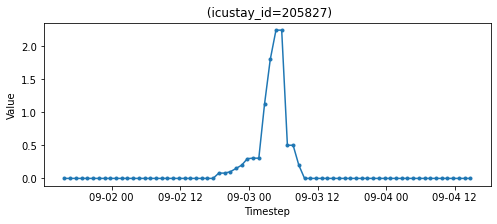

In [11]:
# Example vasopressor trajectory from MV
plot_single(sampled_vaso_mv_df, item_id='max_vaso')

In [12]:
# How many admissions were recorded in MetaVision?
vaso_mv_episodes = sampled_vaso_mv_df.episode.unique()
print('MetaVision max_vaso records: %s' % len(vaso_mv_episodes))

MetaVision max_vaso records: 4137


### 2. CareVue Records (Optional)

In [13]:
if USE_CAREVUE:
    # Load converted CV data
    vaso_cv_df = read_csv(DATA_DIR + 'vassopressors_cv_cohort_v2.csv')

    # Process admissions one-by-one
    sampled_vaso_cv_dfs = []
    for icustay_id, treatments in tqdm(vaso_cv_df.groupby('icustay_id')):

        # Part of sepsis-3 cohort?
        if icustay_id not in cohort:
            continue
            
        # Skip admission if already in MV
        if icustay_id in vaso_mv_episodes:
            continue

        # Empty vector to store max_vaso values into
        intervals = interval_times[icustay_id]
        max_vaso = np.zeros(len(intervals), dtype=np.float64)

        for i, (interval_start, interval_end) in enumerate(intervals):        
            # Inclusion test: treatment timeframe overlaps with current interval.
            condition = (treatments['starttime'] <= interval_end) & (treatments['endtime'] > interval_start)
            max_vaso[i] = treatments[condition]['mcgkgmin'].max() # Why max?
            
        # NaN (no treatment) -> zero dose
        max_vaso = np.nan_to_num(max_vaso, nan=0.0)

        # Create DataFrame for ICU stay
        sampled_vaso_cv_df = pd.DataFrame({'timestep': [start for start, _ in intervals],
                                           'episode': icustay_id,
                                           'type': 'max_vaso',
                                           'value': max_vaso})
        sampled_vaso_cv_dfs.append(sampled_vaso_cv_df)

    # Concat DataFrames of individual icustays
    sampled_vaso_cv_df = pd.concat(sampled_vaso_cv_dfs)
    
    del vaso_cv_df, sampled_vaso_cv_dfs

In [14]:
# Plot example vasopressor trajectory from CareVue
if USE_CAREVUE:
    plot_single(sampled_vaso_cv_df, item_id='max_vaso')

In [15]:
# How many admissions were recorded in CareVue?
if USE_CAREVUE:
    vaso_cv_episodes = sampled_vaso_cv_df.episode.unique()
    print('CareVue max_vaso records: %s' % len(vaso_cv_episodes))

### Combine CareVue Records with MetaVision (Optional)

In [16]:
# Merge CV and MV records if processed; otherwise just use MV
if USE_CAREVUE:
    sampled_vaso_df = pd.concat([sampled_vaso_mv_df, sampled_vaso_cv_df])
else:
    sampled_vaso_df = sampled_vaso_mv_df

In [17]:
num_admissions = len(sampled_vaso_df['episode'].unique())
print('Total admissions:', num_admissions)

Total admissions: 4137


---
## IV Fluids

### 1. MetaVision Records

In [19]:
# See (Komorowski et al., 2018) 
# https://github.com/matthieukomorowski/AI_Clinician/blob/master/AIClinician_Data_extract_MIMIC3_140219.ipynb
TONICITY_FACTORS = {
    30176: 0.25,
    30315: 0.25,
    30161: 0.3,
    30020: 0.5,
    30015: 0.5,
    225823: 0.5,
    30321: 0.5,
    30186: 0.5,
    30211: 0.5, 
    30353: 0.5,
    42742: 0.5,
    42244: 0.5,
    225159: 0.5,
    227531: 2.75,
    30143: 3,
    225161: 3,
    30009: 5,
    220862: 5,
    30030: 6.66,
    220995: 6.66,
    227533: 6.66,
    228341: 8
}

# Remark: Komorowski et al. missed 220949, 'Dextrose 5%' (isotonic), amounting to 40% of IV fluids!
IV_FLUID_ITEMIDS = {225158,225943,226089,225168,225828,225823,220862,220970,220864,225159,220995,225170,
                    225825,227533,225161,227531,225171,225827,225941,225823,225825,225941,225825,228341,
                    225827,30018,30021,30015,30296,30020,30066,30001,30030,30060,30005,30321,30006,30061,
                    30009,30179,30190,30143,30160,30008,30168,30186,30211,30353,30159,30007,30185,30063,
                    30094,30352,30014,30011,30210,46493,45399,46516,40850,30176,30161,30381,30315,42742,
                    30180,46087,41491,30004,42698,42244,220949,225944,227523}

NON_IV_CATEGORIES = ['14-Oral/Gastric Intake', 
                     '09-Antibiotics (Non IV)',
                     '13-Enteral Nutrition',
                     '06-Insulin (Non IV)',
                     '11-Prophylaxis (Non IV)',
                     '16-Pre Admission',
                     '09-Antibiotics (Non IV)']

**Drop non-IV fluid events**

In [20]:
iv_fluid_mv_df = read_csv(DATA_DIR + 'inputevents_mv_cohort.csv')

# Drop 14-Oral/Gastric Intake (i.e. having a glass of water) and other Non-IV input events
# Remark: In (Roggeveen et al., 2021) only '14-Oral/Gastric Intake' was dropped causing
# various Non-IV treatments (such as '13-Enteral Nutrition') to become part of IV fluids
iv_fluid_mv_df = iv_fluid_mv_df.loc[~iv_fluid_mv_df.ordercategoryname.isin(NON_IV_CATEGORIES) & (iv_fluid_mv_df.amountuom == 'ml')]

# Sanity check: remove amounts outside (0, 5000) range
iv_fluid_mv_df = iv_fluid_mv_df[(iv_fluid_mv_df.amount > 0) & (iv_fluid_mv_df.amount < 5000) & iv_fluid_mv_df.amount.notna()]

# Compute duration in hours
# Remark: original erroneously measured time in a mix of hours and minutes (due to unit='auto')
iv_fluid_mv_df['duration'] = to_hours(iv_fluid_mv_df.endtime - iv_fluid_mv_df.starttime)

# Drop many useless columns
iv_fluid_mv_df = iv_fluid_mv_df[['subject_id', 'hadm_id', 'icustay_id', 'itemid', 'starttime', 'endtime', 'amount', 'duration']]
iv_fluid_mv_df.head()

,subject_id,hadm_id,icustay_id,itemid,starttime,endtime,amount,duration
2,23,124321,234044.0,220949,2157-10-21 15:00:00,2157-10-21 15:01:00,200.000000,0.016667
4,23,124321,234044.0,225158,2157-10-21 12:15:00,2157-10-21 13:22:00,13.432238,1.116667
7,23,124321,234044.0,227523,2157-10-21 17:08:00,2157-10-21 18:08:00,49.999999,1.000000
10,23,124321,234044.0,220949,2157-10-22 08:00:00,2157-10-22 08:01:00,200.000000,0.016667
14,23,124321,234044.0,225158,2157-10-22 09:24:00,2157-10-22 09:48:00,1.602968,0.400000


**Correct for tonicity**

In [21]:
perc_iv_fluids = np.sum(iv_fluid_mv_df.itemid.isin(IV_FLUID_ITEMIDS)) / len(iv_fluid_mv_df)
print('%-known IV solutions:', perc_iv_fluids)

%-known IV solutions: 0.9480357490737755


In [22]:
def correct_for_tonicity(df):
    df = df[df.itemid.isin(IV_FLUID_ITEMIDS)].copy()
    for item_id, factor in TONICITY_FACTORS.items():
        df.loc[df.itemid == item_id, 'amount'] = factor * df.amount[df.itemid == item_id]
    return df

# Remark: Tonicity correction was not done in (Roggeveen et al., 2021) although standard practice
iv_fluid_mv_df = correct_for_tonicity(iv_fluid_mv_df)
iv_fluid_mv_df.head()

,subject_id,hadm_id,icustay_id,itemid,starttime,endtime,amount,duration
2,23,124321,234044.0,220949,2157-10-21 15:00:00,2157-10-21 15:01:00,200.000000,0.016667
4,23,124321,234044.0,225158,2157-10-21 12:15:00,2157-10-21 13:22:00,13.432238,1.116667
7,23,124321,234044.0,227523,2157-10-21 17:08:00,2157-10-21 18:08:00,49.999999,1.000000
10,23,124321,234044.0,220949,2157-10-22 08:00:00,2157-10-22 08:01:00,200.000000,0.016667
14,23,124321,234044.0,225158,2157-10-22 09:24:00,2157-10-22 09:48:00,1.602968,0.400000


**Computing IV fluid intake:**<br>
In order to determine the total amount of IV fluid administered within a 4 hour interval, we need to calculate how long a treatment was administered for during an interval; multiplied by the rate (i.e. `amount / duration`) we can infer the total amount administered by each treatment during the current interval. For this we use the `total_admin_in_interval` function below:

In [23]:
# Computes how much of each dose was administered between interval_start and interval_end
def total_admin_in_interval(interval_start, interval_end, treatments):
    dose_start = treatments.starttime
    dose_end = treatments.endtime
    amount = treatments.amount
    duration = treatments.duration
    rate = amount / duration # in ml/hour!   
    
    total_ml = 0
    
    # Option 1: Dose started before interval and ended after interval
    c1 = (dose_start < interval_start) & (dose_end > interval_end)
    if c1.any():
        total_ml += (to_hours(interval_end - interval_start) * rate[c1]).sum()
    
    # Option 2: Dose started before and ended within interval
    c2 = (dose_start < interval_start) & (dose_end > interval_start) & (dose_end <= interval_end)
    if c2.any():
        total_ml += (to_hours(dose_end - interval_start) * rate[c2]).sum()

    # Option 3: Dose started and ended in interval
    c3 = (dose_start >= interval_start) & (dose_start < interval_end) & (dose_end <= interval_end) & (dose_end > interval_start)
    if c3.any():
        total_ml += amount[c3].sum()
    
    # Option 4: dose started in interval and ended after interval
    # Remark: Extra division by duration in original notebook
    # Remark: Also, > in first term caused treatments to be skipped starting at interval_start exactly
    c4 = (dose_start >= interval_start) & (dose_start < interval_end) & (dose_end > interval_end)
    if c4.any():
        total_ml += (to_hours(interval_end - dose_start) * rate[c4]).sum()
            
    return total_ml

We now use `total_admin_in_interval()` on each interval `(interval_start, interval_end)` and treatments in `ivfluid_mv_df` to compute the total IV fluid administration within each 4 hour interval:

In [24]:
sampled_iv_fluid_mv_dfs = []

# Process admissions one-by-one
for icustay_id, treatments in tqdm(iv_fluid_mv_df.groupby('icustay_id'), desc='Give me a bit'):
    
    # Is icustay part of cohort?
    if icustay_id not in cohort:
        continue
    
    intervals = interval_times[icustay_id]
    total_iv_fluid = np.zeros(len(intervals), dtype=np.float64)
    
    # Compute total IV fluid within each interval
    for i, (interval_start, interval_end) in enumerate(intervals):
        total_iv_fluid[i] = total_admin_in_interval(interval_start, interval_end, treatments)
                
    # Convert to DataFrame
    sampled_iv_fluid_df = pd.DataFrame({'episode': icustay_id,
                                        'timestep': [start for start, _ in intervals],
                                        'type': 'total_iv_fluid',
                                        'value': total_iv_fluid})
    sampled_iv_fluid_mv_dfs.append(sampled_iv_fluid_df)
    
# Concat DataFrames of individual icustays
sampled_iv_fluid_mv_df = pd.concat(sampled_iv_fluid_mv_dfs)
sampled_iv_fluid_mv_df.tail()

Give me a bit: 100%|█████████████████████████████████████████████████████████████| 13540/13540 [28:35<00:00,  7.89it/s]


,episode,timestep,type,value
67,299998.0,2181-07-07 04:12:00,total_iv_fluid,295.9854
68,299998.0,2181-07-07 05:12:00,total_iv_fluid,299.3309
69,299998.0,2181-07-07 06:12:00,total_iv_fluid,300.0000
70,299998.0,2181-07-07 07:12:00,total_iv_fluid,300.0000
71,299998.0,2181-07-07 08:12:00,total_iv_fluid,1295.0000


In [25]:
del iv_fluid_mv_df, sampled_iv_fluid_mv_dfs

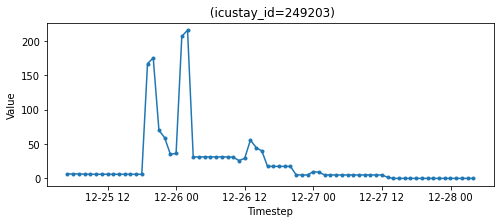

In [26]:
# Get total IV fluid intake for one random patient
plot_single(sampled_iv_fluid_mv_df, item_id='total_iv_fluid')

In [27]:
# How many admissions were recorded in MetaVision?
iv_fluid_mv_episodes = sampled_iv_fluid_mv_df.episode.unique()
print('MetaVision total_iv_fluid records: %s' % len(iv_fluid_mv_episodes))

MetaVision total_iv_fluid records: 9290


### 2. CareVue Records (Optional)

In [28]:
if USE_CAREVUE:
    # Load data
    iv_fluid_cv_df = read_csv(DATA_DIR + 'inputevents_cv_cohort_v2.csv')

    # Sanity check: remove amounts outside (0, 5000) range
    iv_fluid_cv_df = iv_fluid_cv_df.loc[(iv_fluid_cv_df['amount'] > 0) & (iv_fluid_cv_df['amount'] < 5000) & iv_fluid_cv_df['amount'].notna()]

    # Compute duration in hours
    iv_fluid_cv_df['duration'] = (iv_fluid_cv_df['endtime'] - iv_fluid_cv_df['starttime']).astype('timedelta64[s]').astype(int) / 3600

    # Process admissions one-by-one
    sampled_iv_fluid_cv_dfs = []
    for icustay_id, treatments in tqdm(iv_fluid_cv_df.groupby('icustay_id'), desc='Grab another coffee!'):
    
        # Is icustay part of cohort?
        if icustay_id not in cohort:
            continue
            
        # Skip if already recorded by MV
        if icustay_id in iv_fluid_mv_episodes:
            continue

        intervals = interval_times[icustay_id]
        total_iv_fluid = np.zeros(len(intervals), dtype=np.float64)

        # Compute total IV fluid within each interval
        for i, (interval_start, interval_end) in enumerate(intervals):
            total_iv_fluid[i] = total_admin_in_interval(interval_start, interval_end, treatments)

        # Convert to DataFrame
        sampled_iv_fluid_df = pd.DataFrame({'episode': icustay_id,
                                            'timestep': [start for start, _ in intervals],
                                            'type': 'total_iv_fluid',
                                            'value': total_iv_fluid})
        sampled_iv_fluid_cv_dfs.append(sampled_iv_fluid_df)

    # Concat DataFrames of individual admissions
    sampled_iv_fluid_cv_df = pd.concat(sampled_iv_fluid_cv_dfs)
    
    del iv_fluid_cv_df

In [29]:
# Get total IV fluid intake for one random patient
if USE_CAREVUE:
    plot_single(sampled_iv_fluid_cv_df, item_id='total_iv_fluid')

In [30]:
# How many admissions were recorded in CareVue?
if USE_CAREVUE:
    iv_fluid_cv_episodes = sampled_iv_fluid_cv_df.episode.unique()
    print('CareVue total_iv_fluid records: %s' % len(iv_fluid_cv_episodes))

#### Combine CareVue Fluid Records with MetaVision

In [31]:
# Merge CV and MV records if processed; otherwise just use MV
if USE_CAREVUE:
    sampled_iv_fluid_df = pd.concat([sampled_iv_fluid_mv_df, sampled_iv_fluid_cv_df])
else:
    sampled_iv_fluid_df = sampled_iv_fluid_mv_df

In [32]:
num_admissions = len(sampled_iv_fluid_df['episode'].unique())
print('Total admissions:', num_admissions)

Total admissions: 9290


---
## Vitals

Vitals are already in the correct format, therefore we only need to rename the columns, drop unnecessary ones and snake-case the `vital_ids`;

In [33]:
vitals_df = read_csv(DATA_DIR + 'vitals_cohort.csv')

# Simply rename columns (vitals_df is already in the right format)
vitals_df = pd.DataFrame({'episode': vitals_df['icustay_id'],
                          'timestep': vitals_df['charttime'],
                          'type': vitals_df['vital_id'].apply(to_snakecase),
                          'value': vitals_df['valuenum']})
vitals_df.head()

,episode,timestep,type,value
0,294638,2191-03-16 01:30:00,heart_rate,111.000000
1,294638,2191-03-16 01:30:00,sp_o2,98.000000
2,294638,2191-03-16 01:30:00,temp_c,37.444445
3,294638,2191-03-16 02:00:00,dias_bp,63.000000
4,294638,2191-03-16 02:00:00,heart_rate,100.000000


---
## Lab Results

In [34]:
lab_df = read_csv(DATA_DIR + 'labs_cohort.csv')

# Drop NaNs in lab_id column
lab_df = lab_df[lab_df['lab_id'].notna()]

# Simply rename columns (lab_df is already in the right format)
lab_df = pd.DataFrame({'episode': lab_df['icustay_id'],
                       'timestep': lab_df['charttime'],
                       'type': lab_df['lab_id'].apply(to_snakecase),
                       'value': lab_df['valuenum']})
lab_df.head()

,episode,timestep,type,value
0,294638,2191-03-15 14:12:00,alat,28.0
1,294638,2191-03-15 14:12:00,anion gap,17.0
2,294638,2191-03-15 14:12:00,asat,69.0
3,294638,2191-03-15 14:12:00,bicarbonate,24.0
4,294638,2191-03-15 14:12:00,bilirubin,2.2


---
## FiO2 (Fraction of Inspired Oxygen)

In [35]:
fio2_df = read_csv(DATA_DIR + 'fio2_cohort.csv')

fio2_df = pd.DataFrame({'episode': fio2_df['icustay_id'],
                        'timestep': fio2_df['charttime'],
                        'type': 'fi_o2',
                        'value': fio2_df['fio2']})
fio2_df.head()

,episode,timestep,type,value
0,294638,2191-03-16 03:00:00,fi_o2,94.999999
1,294638,2191-03-16 08:00:00,fi_o2,50.000000
2,294638,2191-03-16 11:00:00,fi_o2,NaN
3,220597,2149-11-09 13:40:00,fi_o2,NaN
4,220597,2149-11-09 17:00:00,fi_o2,60.000002


---
## Urine Output

In [36]:
urineoutput_df = read_csv(DATA_DIR + 'urineoutput_cohort.csv')

urineoutput_df = pd.DataFrame({'episode': urineoutput_df['icustay_id'],
                               'timestep': urineoutput_df['charttime'],
                               'type': 'urine_output',
                               'value': urineoutput_df['value']})
urineoutput_df.head()

,episode,timestep,type,value
0,205353,2140-12-01 02:00:00,urine_output,5.0
1,210804,2132-06-03 08:00:00,urine_output,100.0
2,236794,2100-11-01 01:00:00,urine_output,150.0
3,247650,2141-08-23 18:00:00,urine_output,160.0
4,233215,2167-07-28 07:00:00,urine_output,45.0


---
## Demographics

We repeat demographics at every decision point as we may need to truncate the sequence when it gets too long; then demographic information stored at the beginning of the sequence may be lost (e.g. as they were measured on admission)...

In [37]:
USED_DEMOGRAPHICS = ['age', 'height', 'is_male', 'weight', 'vent', 'sofa', 'sirs']

In [38]:
demo_df = read_csv(DATA_DIR + 'demographics_cohort.csv')[['icustay_id'] + USED_DEMOGRAPHICS]

# Merge table to be able to access window_start
demo_df = demo_df.merge(cohort_df[['icustay_id', 'window_start']], on='icustay_id', how='inner')
demo_df.head()

,icustay_id,age,height,is_male,weight,vent,sofa,sirs,window_start
0,200003,48.2940,177.80,1,77.0,1,6,4,2199-08-01 21:02:00
1,200014,84.7274,167.64,1,62.0,1,3,4,2105-02-16 00:00:00
2,200019,82.8820,NaN,0,65.0,1,5,3,2178-07-07 21:51:00
3,200030,54.1915,187.96,1,113.6,0,7,4,2150-11-12 00:00:00
4,200035,30.6591,NaN,1,95.5,0,2,3,2156-10-06 16:50:00


In [39]:
one_minute = pd.to_timedelta('1m')

# Create df with demographics as measurements
demo_dfs = []
for icustay_id, icustay_demo_df in tqdm(demo_df.groupby('icustay_id')):
    
    # Repeat demographics at every decision point! 
    for feat in USED_DEMOGRAPHICS:
        demo_df2 = pd.DataFrame({'episode': icustay_id,
                                 'timestep': [start - one_minute for start, _ in interval_times[icustay_id]], # one minute before actual decision point!
                                 'type': feat,
                                 'value': icustay_demo_df[feat].values[0]})
        demo_dfs.append(demo_df2)
    
demo_df = pd.concat(demo_dfs)
demo_df.head()

100%|████████████████████████████████████████████████████████████████████████████| 18346/18346 [03:26<00:00, 88.73it/s]


,episode,timestep,type,value
0,200003,2199-08-01 21:01:00,age,48.294
1,200003,2199-08-01 22:01:00,age,48.294
2,200003,2199-08-01 23:01:00,age,48.294
3,200003,2199-08-02 00:01:00,age,48.294
4,200003,2199-08-02 01:01:00,age,48.294


In [40]:
del demo_dfs

---
## Putting It All Together

In [41]:
# Merge measurement DataFrames
full_df = pd.concat([sampled_vaso_df,
                     demo_df,
                     sampled_iv_fluid_df, 
                     vitals_df, 
                     lab_df, 
                     fio2_df, 
                     urineoutput_df]).dropna(axis=0).reset_index(drop=True)

# Group by admissions and timestep
full_df = full_df.sort_values(by=['episode', 'timestep']).reset_index(drop=True)

In [42]:
shuffled_full_df = full_df.sample(frac=1)
shuffled_full_df.head()

,timestep,episode,type,value
7447430,2130-06-24 10:00:00,244520.0,mean_bp,83.00
11745645,2171-04-18 04:59:00,269549.0,weight,88.70
8842421,2178-07-31 02:00:00,252649.0,sp_o2,97.00
8891903,2191-11-13 17:51:00,252951.0,sofa,7.00
16499622,2182-10-30 06:03:00,297013.0,weight,99.79


In [43]:
del shuffled_full_df

In [44]:
num_admissions = len(full_df['episode'].unique())
print('Total admissions:', num_admissions)

Total admissions: 18346


---
## Add Discretized Action Space and Rewards

In [45]:
# Compute 5-bin histogram to obtain discrete intervals
def get_quantile_intervals(vals, N=5, max_inf=True, min_inf=True):
    # Drop NaNs and zero doses (they get their own action)
    vals = vals[(vals > 0) & ~np.isnan(vals)].values
        
    # Compute quantiles with special zero bin
    quantiles = [0] + list(np.quantile(vals, np.linspace(0, 1, N)))
    quantiles[0] = -np.inf
    quantiles[1] = 0
    quantiles[-1] = np.inf
    return quantiles
    
max_vaso_bins = get_quantile_intervals(full_df.value[full_df.type == 'max_vaso'])
iv_fluid_bins = get_quantile_intervals(full_df.value[full_df.type == 'total_iv_fluid'])

print('Max VP bins:  ', max_vaso_bins)
print('IV fluid bins:', iv_fluid_bins)

Max VP bins:   [-inf, 0, 0.1000715561, 0.2249710084575, 0.449811350505, inf]
IV fluid bins: [-inf, 0, 22.998621479999997, 93.31871506899999, 214.33369112, inf]


#### Export Action Bins and Action-Bin Mapping

In [46]:
# Save bin edges of max_vaso and total_iv_fluid as .npy files for later reference
with open(OUTPUT_DIR + 'max_vaso_bins.npy', 'w') as file:
    np.savetxt(file, max_vaso_bins)
    
with open(OUTPUT_DIR + 'total_iv_fluid_bins.npy', 'w') as file:
    np.savetxt(file, iv_fluid_bins)
    
print('Done!')

Done!


In [47]:
import pickle

# Save mapping from action indices (0 to 24) to bin indices (0 to 4)
action_id_to_bins = dict()
for max_vaso in range(5):
    for total_iv_fluid in range(5):
        action_id_to_bins[5 * total_iv_fluid + max_vaso] = (total_iv_fluid, max_vaso)

with open(OUTPUT_DIR + 'action_to_vaso_fluid_bins.pkl', 'wb') as file:
    pickle.dump(action_id_to_bins, file)
    
print('Done!')

Done!



#### Convert Continuous Actions to 5x5 Action Space

In [48]:
def actions_and_rewards(max_vaso_df, iv_fluid_df, max_vaso_bins, iv_fluid_bins, cohort_df):    
    # Merge vasopressor and IV fluid DataFrames
    action_space_df = pd.concat([max_vaso_df, iv_fluid_df])

    action_reward_dfs = []
    for icustay_id, icustay_df in tqdm(action_space_df.groupby('episode')):
        
        # Get VP and IV records over time
        max_vaso = icustay_df[icustay_df['type'] == 'max_vaso'].sort_values('timestep')
        iv_fluid = icustay_df[icustay_df['type'] == 'total_iv_fluid'].sort_values('timestep')
        
        # If no vasopressors or IV fluids were recorded, assume zeros (no treatment)
        timesteps = [start for start, _ in interval_times[icustay_id]]
        max_vaso = max_vaso['value'].values if len(max_vaso) > 0 else np.zeros(len(timesteps))
        iv_fluid = iv_fluid['value'].values if len(iv_fluid) > 0 else np.zeros(len(timesteps))

        # Discretize to 5x5 action space using precomputed bins
        max_vaso_discrete = pd.cut(x=max_vaso, 
                                   bins=max_vaso_bins, 
                                   labels=[0, 1, 2, 3, 4], 
                                   include_lowest=True).astype(float)

        iv_fluid_discrete = pd.cut(x=iv_fluid, 
                                   bins=iv_fluid_bins, 
                                   labels=[0, 1, 2, 3, 4], 
                                   include_lowest=True).astype(float)

        actions = 5 * iv_fluid_discrete + max_vaso_discrete
        
        # Determine rewards based on hospital_expire_flag in cohort.csv
        deceased = cohort_df[cohort_df['icustay_id'] == icustay_id]['hospital_expire_flag'].values[0]
        rewards = np.zeros(len(timesteps))
        rewards[-1] = 15 if not deceased else -15

        # Merge into DataFrame
        action_df = pd.DataFrame({'timestep': timesteps,
                                  'episode': icustay_id,
                                  'type': 'action',
                                  'value': 0,  # -> Nothing is measured
                                  'action': actions,
                                  'reward': rewards})
        action_reward_dfs.append(action_df)

    # Concat DataFrames of individual icustays
    action_reward_df = pd.concat(action_reward_dfs).reset_index(drop=True)
    return action_reward_df

In [49]:
action_reward_df = actions_and_rewards(sampled_vaso_df, sampled_iv_fluid_df, max_vaso_bins, iv_fluid_bins, cohort_df)

print('Num decision times: %s\n' % len(action_reward_df))
action_reward_df.head(18) # Check: Should see some non-zero rewards

100%|█████████████████████████████████████████████████████████████████████████████| 9290/9290 [00:41<00:00, 224.14it/s]


Num decision times: 668880



,timestep,episode,type,value,action,reward
0,2156-10-06 16:50:00,200035.0,action,0,0.0,0.0
1,2156-10-06 17:50:00,200035.0,action,0,0.0,0.0
2,2156-10-06 18:50:00,200035.0,action,0,0.0,0.0
3,2156-10-06 19:50:00,200035.0,action,0,0.0,0.0
4,2156-10-06 20:50:00,200035.0,action,0,0.0,0.0
5,2156-10-06 21:50:00,200035.0,action,0,0.0,0.0
6,2156-10-06 22:50:00,200035.0,action,0,0.0,0.0
7,2156-10-06 23:50:00,200035.0,action,0,0.0,0.0
8,2156-10-07 00:50:00,200035.0,action,0,0.0,0.0
9,2156-10-07 01:50:00,200035.0,action,0,0.0,0.0


In [50]:
# Add (action, reward) pairs to full_df as new rows
full_df = pd.concat([full_df, action_reward_df])

# Sort to fix ordering
full_df = full_df.sort_values(by=['episode', 'timestep']).reset_index(drop=True)
full_df.head()

,timestep,episode,type,value,action,reward
0,2199-08-01 21:01:00,200003.0,age,48.294,NaN,NaN
1,2199-08-01 21:01:00,200003.0,height,177.800,NaN,NaN
2,2199-08-01 21:01:00,200003.0,is_male,1.000,NaN,NaN
3,2199-08-01 21:01:00,200003.0,weight,77.000,NaN,NaN
4,2199-08-01 21:01:00,200003.0,vent,1.000,NaN,NaN


---

## Drop Impossible Actions

Actions 1 - 4 are not possible as they prescribe VP without IV injection. This is not possible as VP are administered through IV. We will drop any actions of this kind (if there are any) to action 0 (no drug).

In [51]:
full_df.loc[(full_df.type == 'action') & full_df.action.isin([1, 2, 3, 4]), 'action'] = 0

In [52]:
assert not full_df[full_df.type == 'action'].action.isin([1, 2, 3, 4]).any()

---
## Move Vasopressor and IV Fluid by `INTERVAL_TIME`

By moving treatment parameters forward into the future, the model cannot peak at current actions (because it can only look at past values).

In [53]:
# Vasopressor
full_df.loc[full_df['type'] == 'max_vaso', 'timestep'] += pd.to_timedelta(INTERVAL_TIME)

# IV fluids
full_df.loc[full_df['type'] == 'total_iv_fluid', 'timestep'] += pd.to_timedelta(INTERVAL_TIME)

---
## Map Strings of `x0` to Integer IDs
The `x0` feature (storing string ids such as `heart_rate` and `respiratory_rate`) uses strings. To let our transformer model use these IDs for indexing of embeddings, we convert these strings to integer IDs.

In [54]:
measurement_types = list(full_df['type'].unique())

# Make sure 'action' is last ID in 'type'!
measurement_types.remove('action')
measurement_types.append('action')
measurement_types = np.array(measurement_types)

measurement_types

array(['age', 'height', 'is_male', 'weight', 'vent', 'sofa', 'sirs',
       'alat', 'albumin', 'anion gap', 'asat', 'bands', 'bicarbonate',
       'bilirubin', 'bun', 'calcium', 'chloride', 'creatinine', 'glucose',
       'hemoglobin', 'magnesium', 'platelet', 'potassium', 'pt', 'ptt',
       'sodium', 'wbc', 'dias_bp', 'heart_rate', 'mean_bp', 'resp_rate',
       'sp_o2', 'sys_bp', 'urine_output', 'temp_c', 'base_excess',
       'ion_calcium', 'lactate', 'paco2', 'pao2', 'ph', 'fi_o2',
       'total_iv_fluid', 'max_vaso', 'action'], dtype='<U14')

In [55]:
# Create dict to map from string IDs to integer IDs (starting at 1)
mapping = {m:i + 1 for i, m in enumerate(measurement_types)}

# Convert `x0` to integer IDs
full_df['type'] = full_df['type'].replace(mapping)
full_df.head()
print('Done!')

Done!


In [56]:
# Save mapping as file for later reference
with open(OUTPUT_DIR + 'measurement_ids.txt', 'w') as file:
    file.write('\n'.join(measurement_types))

---
## Exclude No-Treatment Admissions
There are some admissions in which no hemodynamic treatments are prescribed; we will filter out these treatments as done in Roggeveen et al.;

In [57]:
# Identify admissions where treatments were registered (at least one action > 0)
admission_has_treatment = full_df.groupby('episode', sort=False)['action'].max() > 0
icustay_ids = admission_has_treatment.index[admission_has_treatment.values]

# Drop all non-treatment admissions
full_df = full_df[full_df['episode'].isin(icustay_ids)]

In [58]:
# How many admissions do we have left?
print('Number of admissions after filtering:', len(icustay_ids))

Number of admissions after filtering: 8028


---
## Train/Valid/Test Split
We will use the dataset split created in `MIMIC-III_preprocessing_roggeveen.ipynb` to allow a fair comparison between models;

In [59]:
train_icustay_ids = np.loadtxt(OUTPUT_DIR_ROGGEVEEN + '/mimic-iii_icustay_ids_train.npy')
valid_icustay_ids = np.loadtxt(OUTPUT_DIR_ROGGEVEEN + '/mimic-iii_icustay_ids_valid.npy')
test_icustay_ids = np.loadtxt(OUTPUT_DIR_ROGGEVEEN + '/mimic-iii_icustay_ids_test.npy')

# Timestamped measurements, e.g. vitals, lab results, vasopressor/IV-fluid doses, etc.
train_df = full_df[full_df['episode'].isin(train_icustay_ids)].copy() # to prevent warnings
valid_df = full_df[full_df['episode'].isin(valid_icustay_ids)].copy()
test_df = full_df[full_df['episode'].isin(test_icustay_ids)].copy()

assert set(train_df.episode.unique()) == set(train_icustay_ids)
assert set(valid_df.episode.unique()) == set(valid_icustay_ids)
assert set(test_df.episode.unique()) == set(test_icustay_ids)
print('Done!')

Done!


---
## Feature scaling: zero mean 'n unit variance

In [60]:
# Compute averages and stdevs over measurements in training set with same item_id (e.g. 'heart_rate')
item_avg = train_df.groupby('type')['value'].mean().to_dict()
item_std = train_df.groupby('type')['value'].std().to_dict()

# Prevents action (x0=43) from being scaled (causing divide by zero)
item_avg[mapping['action']] = 0
item_std[mapping['action']] = 1

In [61]:
def scale_features_by_item(values):
    item_id = values.name
    return (values - item_avg[item_id]) / item_std[item_id]

# Standardize measurements
train_df['value'] = train_df.groupby('type')['value'].transform(scale_features_by_item)
valid_df['value'] = valid_df.groupby('type')['value'].transform(scale_features_by_item)
test_df['value'] = test_df.groupby('type')['value'].transform(scale_features_by_item)
print('Done!')

Done!


#### Sanity check

In [62]:
# Note: `action` should have std. = 0, everything else std. = 1 with zero mean
pd.DataFrame({'avg.': train_df.groupby('type')['value'].mean().round(3), 
              'std.': train_df.groupby('type')['value'].std().round(3)}).T

type,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,45
avg.,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
std.,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


---
## Add Timestep as Feature (in hours from `window_start`)

In [63]:
def timestep_to_hours(dataset):
    return dataset.groupby('episode')['timestep'].transform(lambda x: to_hours(x - x.min())) 

# Add timestep (starting at 0 hours) as additional feature
train_df['time_hours'] = timestep_to_hours(train_df)
valid_df['time_hours'] = timestep_to_hours(valid_df)
test_df['time_hours'] = timestep_to_hours(test_df)

valid_df.head(10)

,timestep,episode,type,value,action,reward,time_hours
24235,2126-12-12 03:34:00,200126.0,1,1.312012,NaN,NaN,0.000000
24236,2126-12-12 03:34:00,200126.0,3,-1.177709,NaN,NaN,0.000000
24237,2126-12-12 03:34:00,200126.0,4,-0.140290,NaN,NaN,0.000000
24238,2126-12-12 03:34:00,200126.0,5,-1.155179,NaN,NaN,0.000000
24239,2126-12-12 03:34:00,200126.0,6,-0.432813,NaN,NaN,0.000000
24240,2126-12-12 03:34:00,200126.0,7,0.131522,NaN,NaN,0.000000
24241,2126-12-12 04:35:00,200126.0,43,-0.392749,NaN,NaN,1.016667
24242,2126-12-12 03:35:00,200126.0,45,0.000000,0.0,0.0,0.016667
24243,2126-12-12 04:34:00,200126.0,1,1.312012,NaN,NaN,1.000000
24244,2126-12-12 04:34:00,200126.0,3,-1.177709,NaN,NaN,1.000000


## Rename Columns to `x0-x2`

In [64]:
train_df.rename(columns={'type':'x0', 'value':'x1', 'time_hours':'x2'}, inplace=True)
valid_df.rename(columns={'type':'x0', 'value':'x1', 'time_hours':'x2'}, inplace=True)
test_df.rename(columns={'type':'x0', 'value':'x1', 'time_hours':'x2'}, inplace=True)
print('Done!')

Done!


### Sort and Export Datasets

In [65]:
# Sort within episode in order of time (also on x0 to make 'action' last at timestep)
train_df = train_df.sort_values(by=['episode', 'timestep', 'x0'])
valid_df = valid_df.sort_values(by=['episode', 'timestep', 'x0'])
test_df = test_df.sort_values(by=['episode', 'timestep', 'x0'])

# Save training, validation and test sets
train_df.to_csv(OUTPUT_DIR + 'mimic-iii_train.csv', index=False)
valid_df.to_csv(OUTPUT_DIR + 'mimic-iii_valid.csv', index=False)
test_df.to_csv(OUTPUT_DIR + 'mimic-iii_test.csv', index=False)
print('Done!')

Done!


---
## Let's Visualize!

Messy as expected...

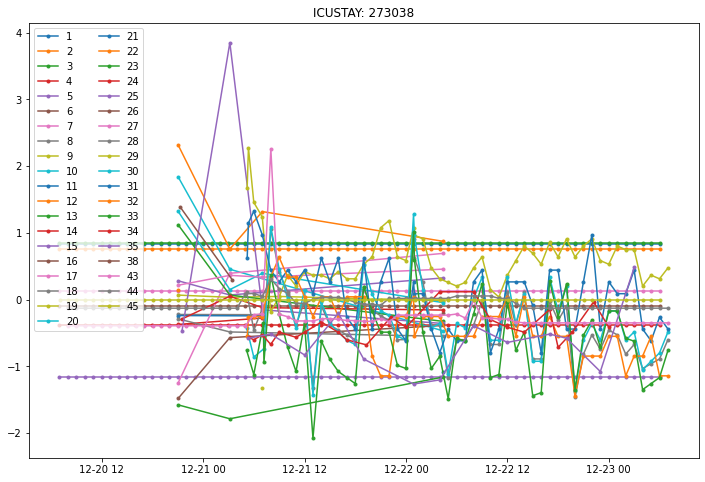

In [72]:
# Sample measurements for one admission by icustay_id
icustay_id = random.choice(train_df['episode'].values)
icustay_df = train_df[train_df['episode'] == icustay_id]

plt.figure(figsize=(12, 8))

for item_id, item_df in icustay_df.groupby('x0'):
    plt.plot(item_df['timestep'], item_df['x1'], '.-', label=item_id)
    
plt.title('ICUSTAY: %d' % icustay_id)
plt.legend(ncol=2)
plt.show()

Note the straight lines which are sampled regularly over time; these represent demographics (e.g. `age` or `weight`). Also, notice that some variables may be missing at times (particularly at the edges of the figure); As we use a transformer there is no need to impute these values: afterall, the physician does not have access to these unknwon measurements either...

In [67]:
print('Dataset sizes:')
print('Train:', train_df[train_df.action.notna()].shape)
print('Valid:', valid_df[valid_df.action.notna()].shape)
print('Test: ', test_df[test_df.action.notna()].shape)

Dataset sizes:
Train: (404568, 7)
Valid: (57744, 7)
Test:  (115704, 7)


In [68]:
train_df.columns

Index(['timestep', 'episode', 'x0', 'x1', 'action', 'reward', 'x2'], dtype='object')